# **Data Collection**

## Objectives

* Download data from Kaggle.com and perform an initial EDA.

## Inputs

* unclean_smartwatch_health_data.csv

## Outputs

* ydata-profiling EDA

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Predictive_Analytics_Project/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Predictive_Analytics_Project'

Include data path

In [4]:
DataUntouched = "inputs/smartwatch_health_data_untouched"

In [5]:
import pandas as pd
data = pd.read_csv(DataUntouched + "/unclean_smartwatch_health_data.csv")
df = pd.DataFrame(data)
print(df.head())

# Change version variable to store outputs in different folder
version = "v1"

OutputFolder = f"outputs/{version}/"
if "outputs" in os.listdir(current_dir):
    if version not in os.listdir(current_dir + "/outputs"):
        os.mkdir(OutputFolder)
else:
    os.makedirs(OutputFolder)

   User ID  Heart Rate (BPM)  Blood Oxygen Level (%)    Step Count  \
0   4174.0         58.939776               98.809650   5450.390578   
1      NaN               NaN               98.532195    727.601610   
2   1860.0        247.803052               97.052954   2826.521994   
3   2294.0         40.000000               96.894213  13797.338044   
4   2130.0         61.950165               98.583797  15679.067648   

  Sleep Duration (hours) Activity Level Stress Level  
0      7.167235622316564  Highly Active            1  
1      6.538239375570314  Highly_Active            5  
2                  ERROR  Highly Active            5  
3      7.367789630207228          Actve            3  
4                    NaN  Highly_Active            6  


# Clean Data

Cleaning will be performed, as from the initial EDA we can see we have 1551 missing cells across all features, Hypothesis 1 doesnt have a target variable as we are looking to perform unsupervised clustering to group. Hypothesis 2's target is Stress Levels and hypothesis 3's is Step Count.

Now we will drop the User ID feature and fix the data types, perform imputation of categoric variables first, perform transformations on numerical data to improve its normality, skewness and kurtosis.
Also try and imporove normality and skewness on the columns that require it.

---

Drop User ID from a copy of the original dataset

In [6]:
df_todrop = df.copy()
df_dropped = df_todrop.drop("User ID", axis=1)

In [7]:
print(df_dropped.columns)
df_dropped.head()
df_dropped.isnull().sum()

Index(['Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count',
       'Sleep Duration (hours)', 'Activity Level', 'Stress Level'],
      dtype='object')


Heart Rate (BPM)          400
Blood Oxygen Level (%)    300
Step Count                100
Sleep Duration (hours)    150
Activity Level            200
Stress Level              200
dtype: int64

Now lets check the initial distribution and general analysis of the one true categorical column Acitivity Level

In [8]:
df_category_test = df_dropped["Activity Level"]
df_category_test.unique()

array(['Highly Active', 'Highly_Active', 'Actve', 'Seddentary',
       'Sedentary', 'Active', nan], dtype=object)

We note the categorical column has 6 unique classes, not including the NaN value

It sticks out that Activity Level has semi duplicated columns, where the names are just slightly different with the same meaning. Classes with more or less the same meaning can be combined for simplicity.

Note that encoding of this categorical column seems likely. The distributions of each class in Actitivity level are well balanced. There should be low bias with this metric


In [9]:
df_category_test.value_counts()

Activity Level
Seddentary       1676
Sedentary        1657
Highly Active    1650
Active           1643
Actve            1622
Highly_Active    1552
Name: count, dtype: int64

Lets take a closer look at the other two data type objects that should be a float64 and int

Next we note that column Sleep Duration (hours) has some cells that include the string "ERROR", we must replace or drop this to impute and change the variables datatype. We could replace this value with NaN, and then impute with the median

In [10]:
df_dropped["Sleep Duration (hours)"].value_counts()

Sleep Duration (hours)
ERROR                 247
4.515512633313341       1
6.192069563693488       1
8.225011860105145       1
7.77547280382428        1
                     ... 
7.809611926858791       1
6.5424774602354105      1
5.690109349564968       1
7.144720940526833       1
9.572659844239388       1
Name: count, Length: 9604, dtype: int64

We also note that column Stress Level includes numbers 1 to 10, and one variable named "Very High", we may replace very high with 11 or a custom value based on dataset knowledge

In [11]:
df_dropped["Stress Level"].value_counts()

Stress Level
2            1007
7            1006
6            1001
3             995
1             984
9             976
4             966
10            954
5             945
8             917
Very High      49
Name: count, dtype: int64

Lets go ahead replace the "Very High" class in the Stress Level column with 11

In [12]:
df_preprocess = df_dropped.copy()

df_preprocess["Stress Level"] = df_preprocess["Stress Level"].replace("Very High", 11)
df_preprocess["Stress Level"].value_counts()

Stress Level
2     1007
7     1006
6     1001
3      995
1      984
9      976
4      966
10     954
5      945
8      917
11      49
Name: count, dtype: int64

Lets replace ERROR cells in the Sleep Duration column with NaN. But Instead of replacing all non-numeric values with NaN we can just use the coerce parameter in pd.to_numeric below, to change any non-numeric values into NaN.

Now lets attempt changing the dtype on the two columns Sleep Duration and Stress Level

In [13]:
# Convert the columns to numeric data types, handling non-numeric values
df_preprocess["Sleep Duration (hours)"] = pd.to_numeric(df_preprocess["Sleep Duration (hours)"], errors='coerce')
df_preprocess["Stress Level"] = pd.to_numeric(df_preprocess["Stress Level"], errors='coerce')

# Check the data types of the columns after conversion
print("Data types after conversion to numeric:")
print(df_preprocess.dtypes)

Data types after conversion to numeric:
Heart Rate (BPM)          float64
Blood Oxygen Level (%)    float64
Step Count                float64
Sleep Duration (hours)    float64
Activity Level             object
Stress Level              float64
dtype: object


Now impute all the numeric columns with the median, as most columns are not normaly distributed yet.

In [14]:
from feature_engine.imputation import MeanMedianImputer

# Define the pipeline with MeanMedianImputer
median_imputer = MeanMedianImputer(imputation_method='median')

# Fit and transform the data using the pipeline
df_processed = median_imputer.fit_transform(df_preprocess)

Now lets attempt changing the dtype on the Stress Level to int64 as to_numeric made it a float.

In [15]:
# Set explicit data types
df_processed["Stress Level"] = df_processed["Stress Level"].astype("int64")

# Check the data types of the columns again
print("Data types after setting explicit types:")
print(df_processed.dtypes)
df_processed.head()

Data types after setting explicit types:
Heart Rate (BPM)          float64
Blood Oxygen Level (%)    float64
Step Count                float64
Sleep Duration (hours)    float64
Activity Level             object
Stress Level                int64
dtype: object


,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,Stress Level
0,58.939776,98.809650,5450.390578,7.167236,Highly Active,1
1,75.220601,98.532195,727.601610,6.538239,Highly_Active,5
2,247.803052,97.052954,2826.521994,6.503308,Highly Active,5
3,40.000000,96.894213,13797.338044,7.367790,Actve,3
4,61.950165,98.583797,15679.067648,6.503308,Highly_Active,6


In [16]:
print(df_processed.columns)

# Check skewness and kurtosis after transformation and imputation
for col in ['Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count',
       'Sleep Duration (hours)', 'Stress Level']:
    print("Skewness and Kurtosis before type change and imputation:")
    print(f"{col} | Skewness: {df_preprocess[col].skew()} | Kurtosis: {df_preprocess[col].kurtosis()}")
    print("\n")
    print("Skewness and Kurtosis after type change and imputation:")
    print(f"{col} | Skewness: {df_processed[col].skew()} | Kurtosis: {df_processed[col].kurtosis()}")
    print("\n")



Index(['Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count',
       'Sleep Duration (hours)', 'Activity Level', 'Stress Level'],
      dtype='object')
Skewness and Kurtosis before type change and imputation:
Heart Rate (BPM) | Skewness: 3.8886812373677984 | Kurtosis: 35.57465239876149


Skewness and Kurtosis after type change and imputation:
Heart Rate (BPM) | Skewness: 3.973562985040958 | Kurtosis: 37.202734787667


Skewness and Kurtosis before type change and imputation:
Blood Oxygen Level (%) | Skewness: -0.5715440023861363 | Kurtosis: -0.30998659609027834


Skewness and Kurtosis after type change and imputation:
Blood Oxygen Level (%) | Skewness: -0.5889504945433629 | Kurtosis: -0.22140785164571275


Skewness and Kurtosis before type change and imputation:
Step Count | Skewness: 1.97201457915679 | Kurtosis: 5.961355681473938


Skewness and Kurtosis after type change and imputation:
Step Count | Skewness: 1.987981880514301 | Kurtosis: 6.059740238843574


Skewness and Kurtosis 

Skewness and Kurtosis definatley needs improvement, transformers will definatley be used on the data in the feature engineering step to improve overall normality.

Lets now identify if we have any outliers in the numerical data, and think what we want to do with them, if they exist.

Directories created successfully or already exist.


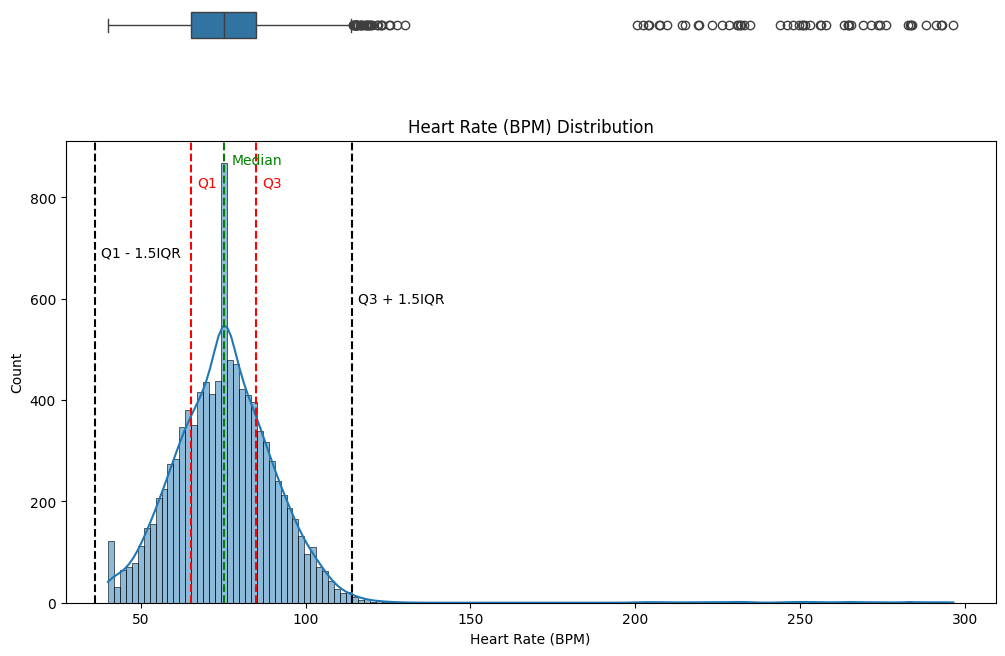

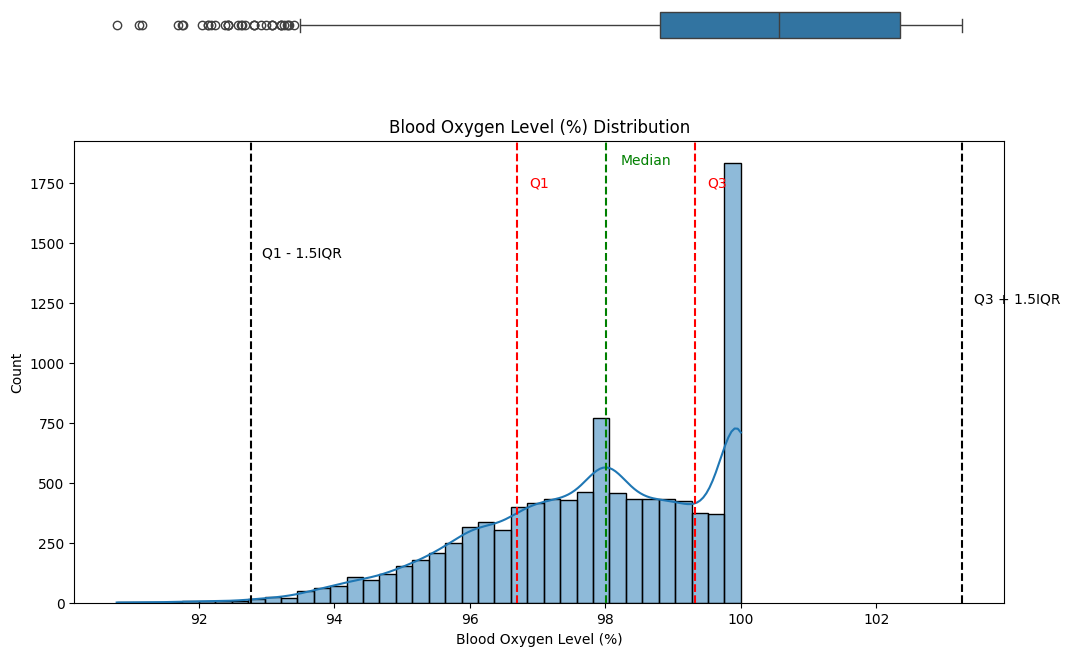

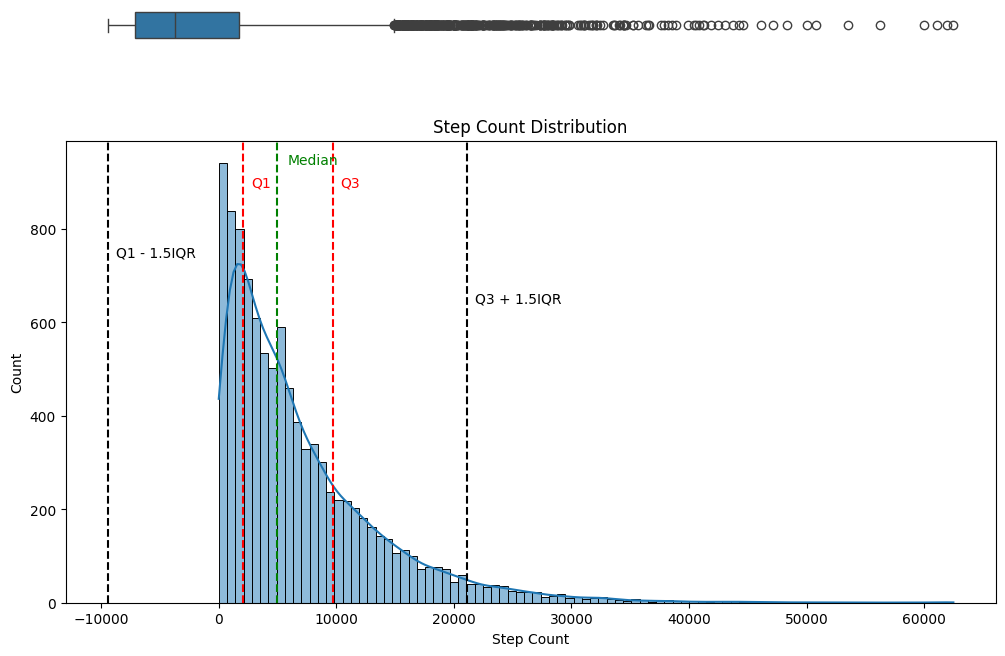

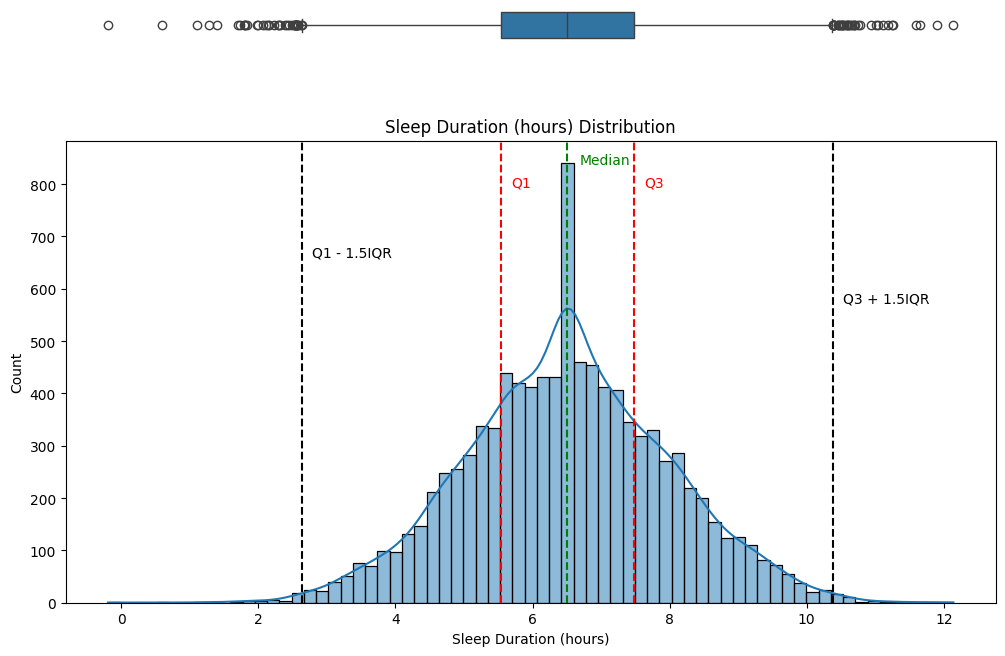

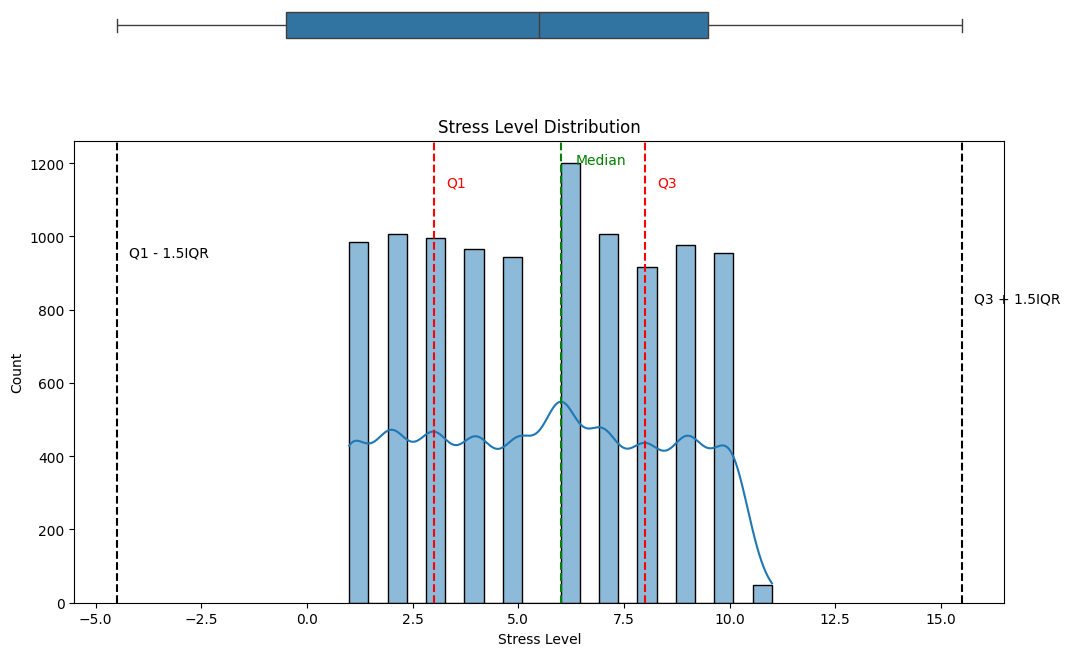

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df = df_processed

OutlierVizBefore = os.path.join(OutputFolder, "outlier_viz/before/")

# Check if the 'before' directory exists, and create it if it does not
if not os.path.exists(OutlierVizBefore):
    os.makedirs(OutlierVizBefore)

OutlierVizAfter = OutlierVizBefore.replace("before", "after")

# Check if the 'after' directory exists, and create it if it does not
if not os.path.exists(OutlierVizAfter):
    os.makedirs(OutlierVizAfter)

print("Directories created successfully or already exist.")

for col in df.select_dtypes(include='number').columns:
    fig, axes = plt.subplots(figsize=(12, 6))
    plt.title(f"{col} Distribution")
    sns.histplot(data=df, x=col, kde=True, ax=axes)

    # Add median line
    plt.axvline(df[col].median(), color='g', linestyle='dashed', linewidth=1.5)
    plt.text(x=df[col].median() + df[col].std()/8, y=axes.get_ylim()[1] * 0.95, s='Median', fontsize=10, c='g')

    # Calculate IQR
    IQR = df[col].quantile(q=0.75) - df[col].quantile(q=0.25)

    # Add Q1 line
    plt.axvline(df[col].quantile(q=0.25), color='r', linestyle='dashed', linewidth=1.5)
    plt.text(x=df[col].quantile(q=0.25) + df[col].std()/10, y=axes.get_ylim()[1] * 0.90, s="Q1", fontsize=10, c='r')

    # Add Q1 - 1.5IQR line
    plt.axvline(df[col].quantile(q=0.25) - 1.5*IQR, color='k', linestyle='dashed', linewidth=1.5)
    plt.text(x=df[col].quantile(q=0.25) - 1.5*IQR + df[col].std()/10, y=axes.get_ylim()[1] * 0.75, s="Q1 - 1.5IQR", fontsize=10, c='k')

    # Add Q3 line
    plt.axvline(df[col].quantile(q=0.75), color='r', linestyle='dashed', linewidth=1.5)
    plt.text(x=df[col].quantile(q=0.75) + df[col].std()/10, y=axes.get_ylim()[1] * 0.90, s="Q3", fontsize=10, c='r')

    # Add Q3 + 1.5IQR line
    plt.axvline(df[col].quantile(q=0.75) + 1.5*IQR, color='k', linestyle='dashed', linewidth=1.5)
    plt.text(x=df[col].quantile(q=0.75) + 1.5*IQR + df[col].std()/10, y=axes.get_ylim()[1] * 0.65, s="Q3 + 1.5IQR", fontsize=10, c='k')

    # Add boxplot on the top margin
    inset_ax = inset_axes(axes, width="100%", height="35%", loc='upper center', bbox_to_anchor=(0, 1.1, 1, 0.2), bbox_transform=axes.transAxes)
    sns.boxplot(data=df, x=col, ax=inset_ax, orient='h')
    inset_ax.set_axis_off()  # Hide the axis for the inset boxplot

    plt.show()
    fig.savefig(OutlierVizBefore + f"{col}_distribution.png")
    print("\n")

We can see from the visuals that in all numerical columns apart from Stress Level, there are outliers. This will be noted

Lets use the Winsorizer with an IQR capping method, looking at the just generated plots top margin boxplots, i feel that for Sleep Duration a double tail winsorizer will be good, Heart Rate tail to the right, Bloody Oxygen to the left and Step Count to the right.

In [18]:
from feature_engine.outliers import Winsorizer

df_outliers = df_processed.copy()

# Define the Winsorizer for each column with different capping methods
winsorizer_sleep_duration = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['Sleep Duration (hours)'])
winsorizer_heart_rate = Winsorizer(capping_method='iqr', tail='right', fold=1.5, variables=['Heart Rate (BPM)'])
winsorizer_blood_oxygen = Winsorizer(capping_method='iqr', tail='left', fold=1.5, variables=['Blood Oxygen Level (%)'])
winsorizer_step_count = Winsorizer(capping_method='iqr', tail='right', fold=1.5, variables=['Step Count'])

# Apply the Winsorizer to each column
df_outliers = winsorizer_sleep_duration.fit_transform(df_outliers)
df_outliers = winsorizer_heart_rate.fit_transform(df_outliers)
df_outliers = winsorizer_blood_oxygen.fit_transform(df_outliers)
df_outliers = winsorizer_step_count.fit_transform(df_outliers)

Now lets visualise the outlier again after the Winsorizer

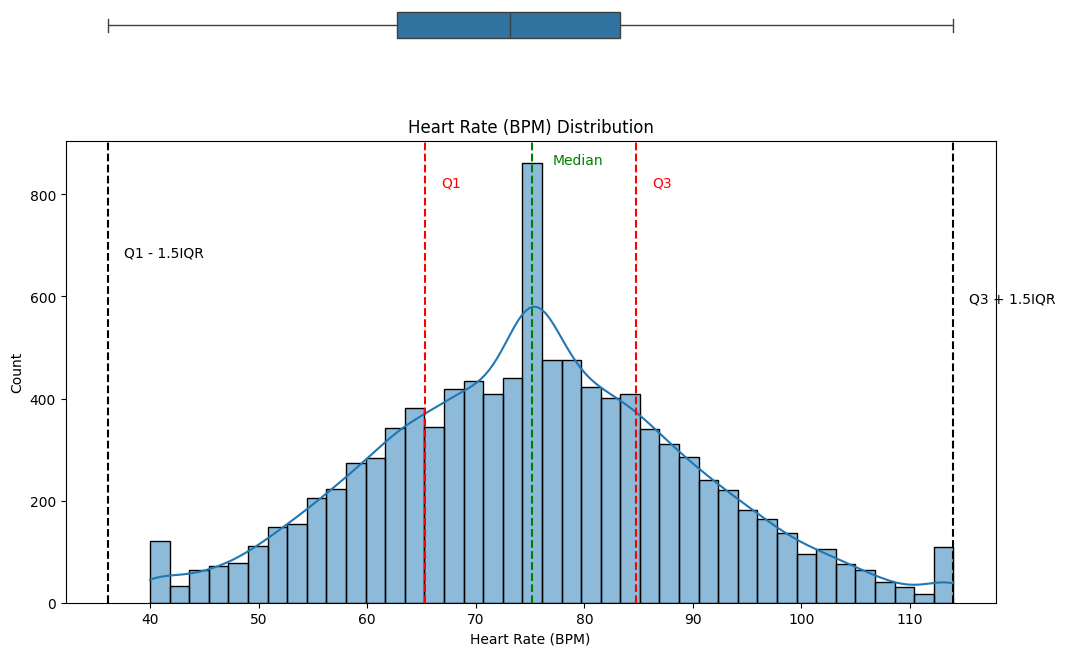

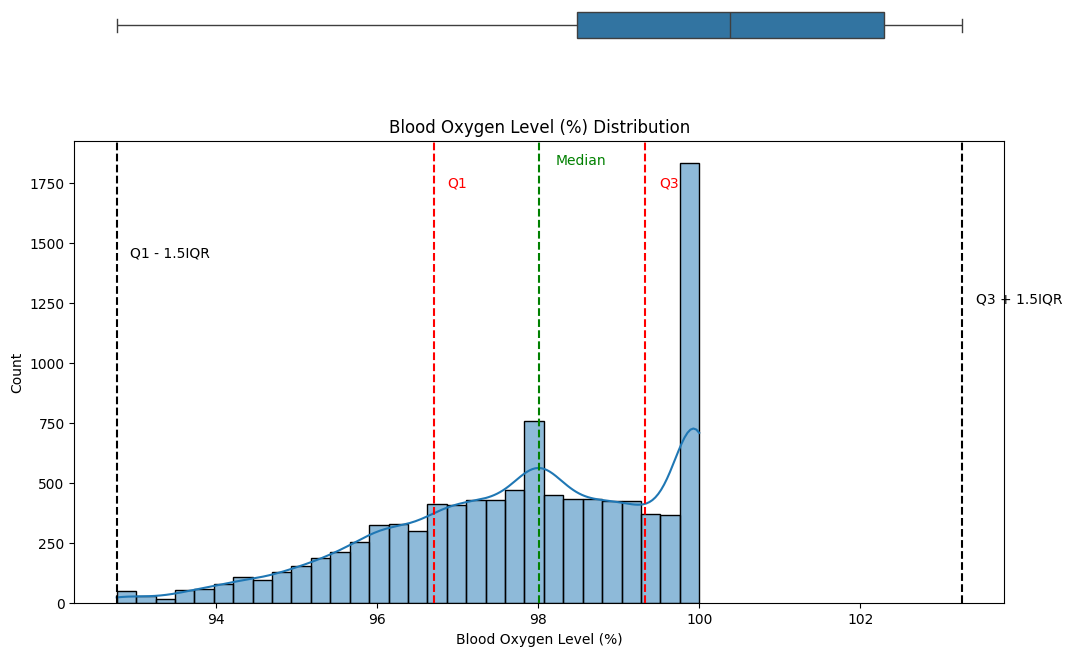

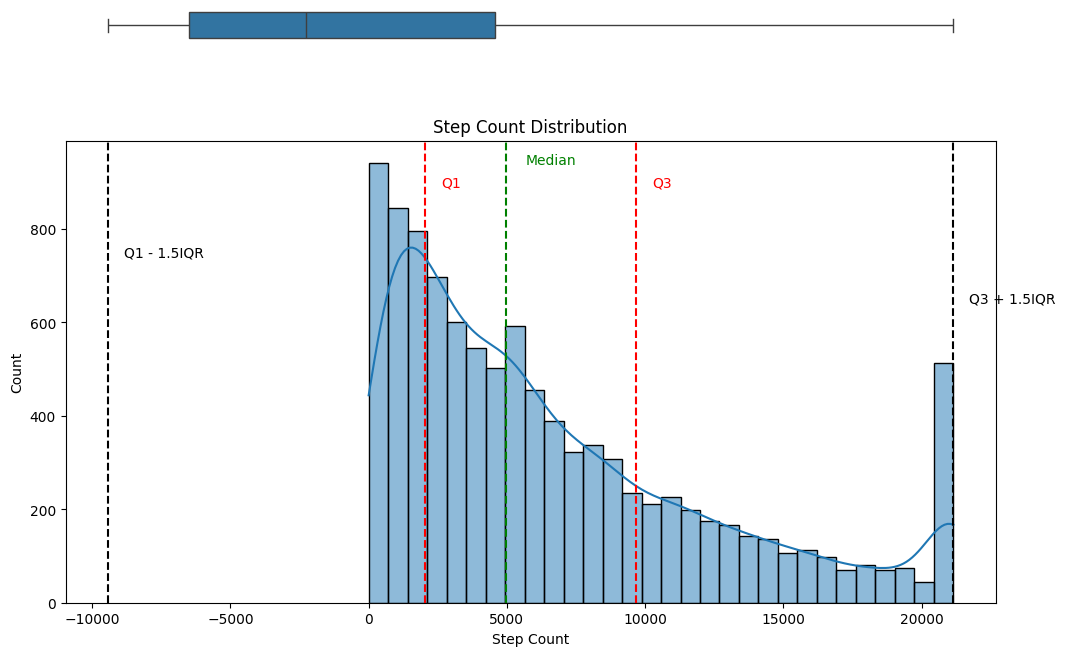

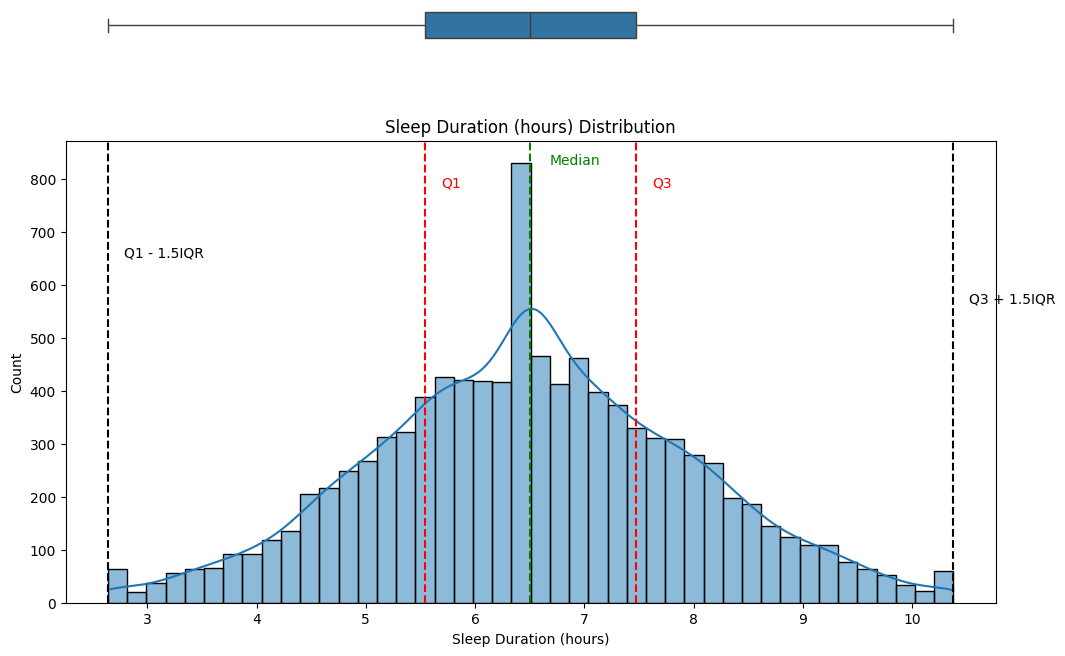

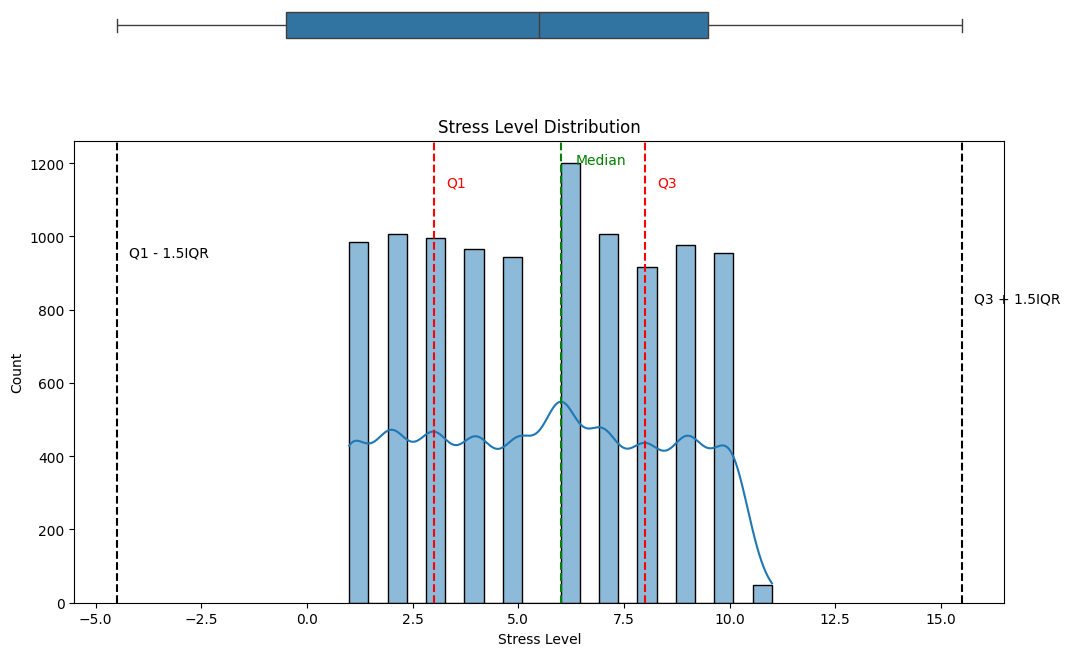

In [19]:
df = df_outliers

for col in df.select_dtypes(include='number').columns:
    fig, axes = plt.subplots(figsize=(12, 6))
    plt.title(f"{col} Distribution")
    sns.histplot(data=df, x=col, kde=True, ax=axes)

    # Add median line
    plt.axvline(df[col].median(), color='g', linestyle='dashed', linewidth=1.5)
    plt.text(x=df[col].median() + df[col].std()/8, y=axes.get_ylim()[1] * 0.95, s='Median', fontsize=10, c='g')

    # Calculate IQR
    IQR = df[col].quantile(q=0.75) - df[col].quantile(q=0.25)

    # Add Q1 line
    plt.axvline(df[col].quantile(q=0.25), color='r', linestyle='dashed', linewidth=1.5)
    plt.text(x=df[col].quantile(q=0.25) + df[col].std()/10, y=axes.get_ylim()[1] * 0.90, s="Q1", fontsize=10, c='r')

    # Add Q1 - 1.5IQR line
    plt.axvline(df[col].quantile(q=0.25) - 1.5*IQR, color='k', linestyle='dashed', linewidth=1.5)
    plt.text(x=df[col].quantile(q=0.25) - 1.5*IQR + df[col].std()/10, y=axes.get_ylim()[1] * 0.75, s="Q1 - 1.5IQR", fontsize=10, c='k')

    # Add Q3 line
    plt.axvline(df[col].quantile(q=0.75), color='r', linestyle='dashed', linewidth=1.5)
    plt.text(x=df[col].quantile(q=0.75) + df[col].std()/10, y=axes.get_ylim()[1] * 0.90, s="Q3", fontsize=10, c='r')

    # Add Q3 + 1.5IQR line
    plt.axvline(df[col].quantile(q=0.75) + 1.5*IQR, color='k', linestyle='dashed', linewidth=1.5)
    plt.text(x=df[col].quantile(q=0.75) + 1.5*IQR + df[col].std()/10, y=axes.get_ylim()[1] * 0.65, s="Q3 + 1.5IQR", fontsize=10, c='k')

    # Add boxplot on the top margin
    inset_ax = inset_axes(axes, width="100%", height="35%", loc='upper center', bbox_to_anchor=(0, 1.1, 1, 0.2), bbox_transform=axes.transAxes)
    sns.boxplot(data=df, x=col, ax=inset_ax, orient='h')
    inset_ax.set_axis_off()  # Hide the axis for the inset boxplot

    plt.show()
    fig.savefig(OutlierVizAfter + f"{col}_distribution.png")
    print("\n")

As we can see with the plots after the Winsorizer, that we have made a siginificant improvement visually. When checking skewness and kurtosis again compared to when we last tested it during the imputation, we can see a dramatic improvement to Heart Rate, a slight change with Blood Oxygen Levels , a decent improvement to Step Counts Kurtosis and small changes to Sleep Duration and Stress level. During feature engineering it seems benificial to perform transformations to try improve normality, skewness and kurtosis further.

In [20]:
# Check skewness and kurtosis after transformation and imputation
for col in ['Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count',
       'Sleep Duration (hours)', 'Stress Level']:
    print("Skewness and Kurtosis before type change, imputation and outlier changes:")
    print(f"{col} | Skewness: {df_processed[col].skew()} | Kurtosis: {df_processed[col].kurtosis()}")
    print("\n")
    print("Skewness and Kurtosis after type change, imputation and outlier changes:")
    print(f"{col} | Skewness: {df[col].skew()} | Kurtosis: {df[col].kurtosis()}")
    print("\n")

Skewness and Kurtosis before type change, imputation and outlier changes:
Heart Rate (BPM) | Skewness: 3.973562985040958 | Kurtosis: 37.202734787667


Skewness and Kurtosis after type change, imputation and outlier changes:
Heart Rate (BPM) | Skewness: 0.08701458277675869 | Kurtosis: -0.10426510784451404


Skewness and Kurtosis before type change, imputation and outlier changes:
Blood Oxygen Level (%) | Skewness: -0.5889504945433629 | Kurtosis: -0.22140785164571275


Skewness and Kurtosis after type change, imputation and outlier changes:
Blood Oxygen Level (%) | Skewness: -0.555459884919862 | Kurtosis: -0.3707332993309622


Skewness and Kurtosis before type change, imputation and outlier changes:
Step Count | Skewness: 1.987981880514301 | Kurtosis: 6.059740238843574


Skewness and Kurtosis after type change, imputation and outlier changes:
Step Count | Skewness: 1.0526163173384016 | Kurtosis: 0.21469906667628624


Skewness and Kurtosis before type change, imputation and outlier change

Lets now impute the one true object (categoric) column, we noted earlier this columns has 6 unique classes with evenly distributed values. But semi duplicated class names.

In [21]:
df["Activity Level"].value_counts()

Activity Level
Seddentary       1676
Sedentary        1657
Highly Active    1650
Active           1643
Actve            1622
Highly_Active    1552
Name: count, dtype: int64

In [22]:
df["Activity Level"].isnull().sum()

np.int64(200)

There a a few approaches to imputing categorical data, i am consdiering random imputation by replacing missing values with a random existing value, or quickly train a algorithm to predict what the missing cells would have contained. I feel predicting the missing categorical values will retain the most information about the data.

In [23]:
from sklearn.ensemble import RandomForestClassifier

df_cat_predict = df.copy()

# Encode categorical column.
# Preserving NaNs by replacing -1 with pd.NA.
df_cat_predict["Activity Level"] = df_cat_predict["Activity Level"].astype("category")
df_cat_predict["Activity Level"] = df_cat_predict["Activity Level"].cat.codes.replace(-1, pd.NA)

# Manually split data temporarily
train = df_cat_predict.dropna(subset=["Activity Level"])
test = df_cat_predict[df_cat_predict["Activity Level"].isna()]

# Define features and target
X_train = train.drop(columns=["Activity Level"])
y_train = train["Activity Level"].astype("int") # Ensure the target is integer type
X_test = test.drop(columns=["Activity Level"])

# Train a throwaway Random Forest model to predict missing values
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Predict missing values
predictions = classifier.predict(X_test)

# Impute the missing values
df_cat_predict.loc[df_cat_predict["Activity Level"].isna(), "Activity Level"] = predictions

# Ensure the Activity Level column contains only integer codes else the next step will fail
df_cat_predict["Activity Level"] = df_cat_predict["Activity Level"].astype("int")

# Decode the categorical column back to original categories
original_categories = df["Activity Level"].astype("category").cat.categories
df_cat_predict["Activity Level"] = pd.Categorical.from_codes(df_cat_predict["Activity Level"], categories=original_categories)


The code first encodes the "Activity Level" column to numerical codes while preserving missing values as NaN.
It then splits the data into training and test sets based on the presence of missing values.
A Random Forest classifier is trained on the non-missing data to predict the missing values.
The missing values are imputed using the predictions from the Random Forest model.
Finally, the numerical codes are converted back to the original categories, and the imputed DataFrame is displayed.

We can compare the Activity Level columns value counts before and after the predictive imputation

In [24]:
print(df_category_test.value_counts())
df_cat_predict["Activity Level"].value_counts()

Activity Level
Seddentary       1676
Sedentary        1657
Highly Active    1650
Active           1643
Actve            1622
Highly_Active    1552
Name: count, dtype: int64


Activity Level
Seddentary       1717
Highly Active    1686
Sedentary        1685
Active           1671
Actve            1661
Highly_Active    1580
Name: count, dtype: int64

Lets now fix the semi duplicated columns by mapping the similar classes to eachother

In [25]:
df_dupe_fix = df_cat_predict.copy()

# Define map
class_mapping = {
    "Seddentary": "Sedentary",
    "Highly_Active": "Highly Active",
    "Actve": "Active"
}

# Replace the misspelled values
df_dupe_fix["Activity Level"] = df_dupe_fix["Activity Level"].replace(class_mapping)

# Display new counts after combining
df_dupe_fix["Activity Level"].value_counts()

/tmp/ipykernel_61964/1340847895.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_dupe_fix["Activity Level"] = df_dupe_fix["Activity Level"].replace(class_mapping)


Activity Level
Sedentary        3402
Active           3332
Highly Active    3266
Name: count, dtype: int64

Notice also that Activity Level is now a category data type

In [26]:
df_dupe_fix.dtypes

Heart Rate (BPM)           float64
Blood Oxygen Level (%)     float64
Step Count                 float64
Sleep Duration (hours)     float64
Activity Level            category
Stress Level                 int64
dtype: object

### Section 2 Save our cleaned data

---

In [38]:
df = df_dupe_fix.copy()

InputFolder = "inputs/"
CleanedData = os.path.join(InputFolder, "cleaned_data/")
HypothesisOne = os.path.join(CleanedData, "hypothesis_one_data/")

# Check if the 'cleaned_data/hypothesis_one_data' directory exists, and create it if it does not
if not os.path.exists(HypothesisOne):
    os.makedirs(HypothesisOne)
df.to_csv(os.path.join(HypothesisOne, "cleaned_smartwatch_health_data.csv"), index=False)

print("Data saved successfully.")

Data saved successfully.


Lets also now split our data into train and test sets

NOTE: This split is for hypothesis 2 and 3, we dont need to split our dataset for hypothesis 1 as this will be a clustering task, we need to perform feature engineering first to find the groupings/patterns.

In [41]:
HypothesisTwo = CleanedData + "hypothesis_two_data/"
if "hypothesis_two_data" not in os.listdir(CleanedData):
    os.mkdir(HypothesisTwo)
    
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(df.drop(['Stress Level'],axis=1),
                                                    df['Stress Level'],
                                                    test_size=0.2,
                                                    random_state=101)

# Is good practice to inspect the shape of the Train and Test sets.
print("* Train set:", TrainSet.shape, "\n* Test set:",  TestSet.shape)

TrainSet.to_csv(HypothesisTwo + "TrainSet.csv", index=False)
TestSet.to_csv(HypothesisTwo + "TestSet.csv", index=False)


* Train set: (8000, 5) 
* Test set: (2000, 5)


In [42]:
HypothesisThree = CleanedData + "hypothesis_three_data/"
if "hypothesis_three_data" not in os.listdir(CleanedData):
    os.mkdir(HypothesisThree)
    
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(df.drop(['Step Count'],axis=1),
                                                    df['Step Count'],
                                                    test_size=0.2,
                                                    random_state=101)

# Is good practice to inspect the shape of the Train and Test sets.
print("* Train set:", TrainSet.shape, "\n* Test set:",  TestSet.shape)

TrainSet.to_csv(HypothesisThree + "TrainSet.csv", index=False)
TestSet.to_csv(HypothesisThree + "TestSet.csv", index=False)



* Train set: (8000, 5) 
* Test set: (2000, 5)


Lets assess to quality of the data cleaning


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count', 'Sleep Duration (hours)', 'Stress Level'] 




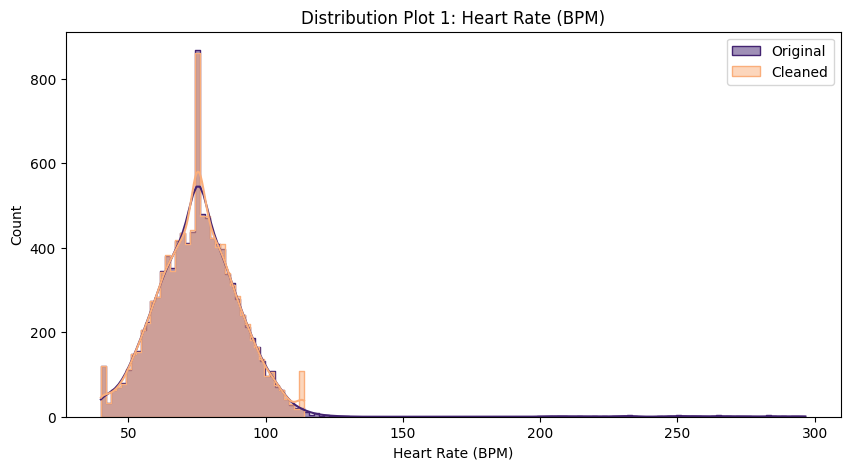

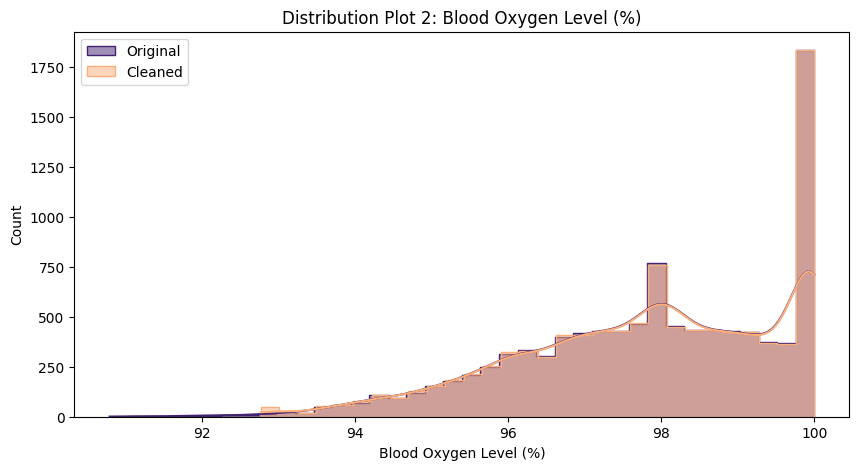

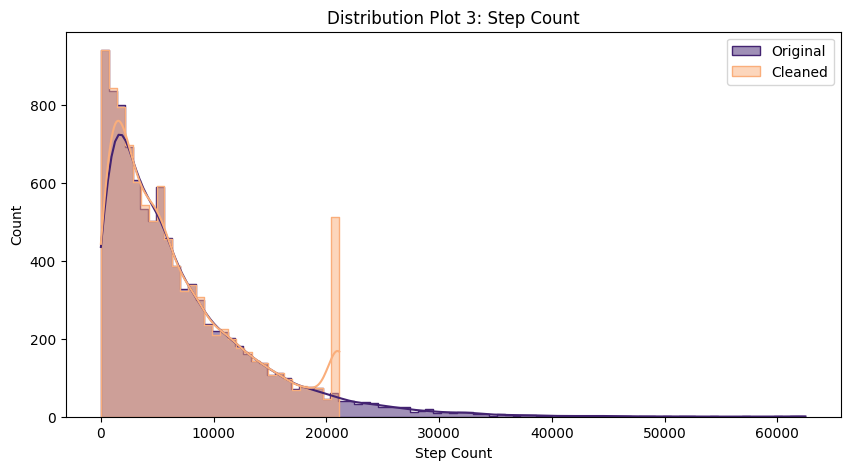

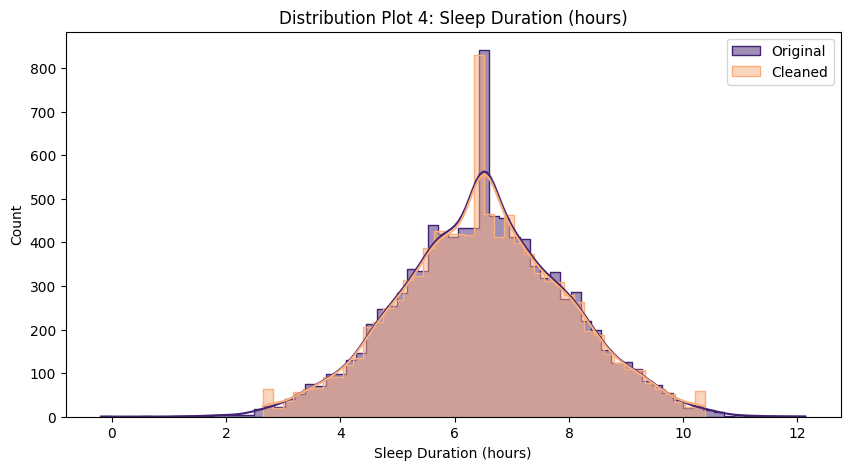

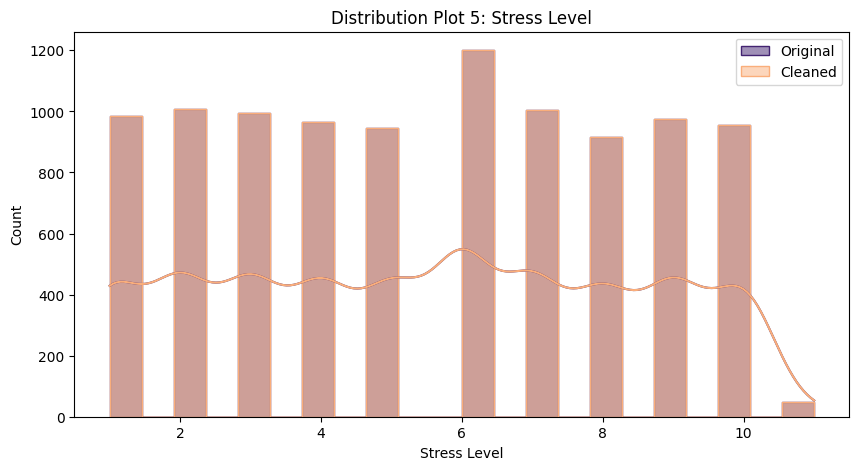


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['Activity Level'] 




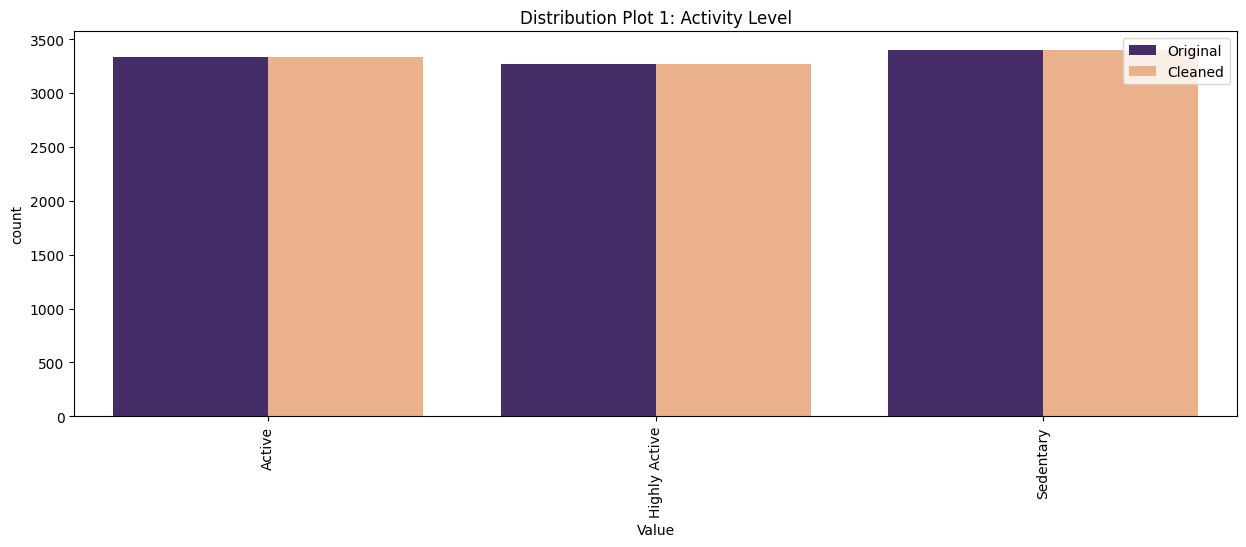

In [37]:
variables_method = ['Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count', 'Sleep Duration (hours)', 'Stress Level']
variables_method2 = ['Activity Level']

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1
      

DataCleaningEffect(df_original=df_processed,
                   df_cleaned=df,
                   variables_applied_with_method=variables_method)
DataCleaningEffect(df_original=df_dupe_fix,
                   df_cleaned=df,
                   variables_applied_with_method=variables_method2)

The data for all 3 hypothesis has been cleaned, and ready for feature engineering.

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
